In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import markers
import json
import psycopg2

In [46]:
sns.set_style('whitegrid')
all_shapes = list(markers.MarkerStyle.markers.keys())
f = open('/Users/aliglara/Documents/MyGit/apis/credential_keys.json', "r")
keys = json.load(f)

In [47]:
def connect_database(server, project, credentials):
    conn = psycopg2.connect(
        host=credentials['databases'][server][project]['host'],
        user=credentials['databases'][server][project]['user'],
        password=credentials['databases'][server][project]['password'],
        database=credentials['databases'][server][project]['database'],
        port=credentials['databases'][server][project]['port']
    )
    return conn.cursor()

# Grabbing homelessness data

The dataset is taking from a Heroku server in order to brush up on SQL coding. However, the original csv files are available in the GitHub repository
Click on -> ([link](https://github.com/aliglara/capstone-c1-DA/tree/main/data))

Let's grab all the information about US homeless population available

In [48]:
cursor = connect_database("heroku", "c1_capstone", keys)
query = ("SELECT ohr.year, ohr.abbreaviation, ohr.homeless_pop "
         "FROM overall_homeless AS ohr "
         "ORDER BY ohr.abbreaviation")
cursor.execute(query)
results = cursor.fetchall()
cursor.close()

In [49]:
column_names = [i[0] for i in cursor.description]
homeless_df = pd.DataFrame(results, columns=column_names)

In [50]:
homeless_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           336 non-null    int64  
 1   abbreaviation  336 non-null    object 
 2   homeless_pop   328 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.0+ KB


There are some null values in the homeless_pop field. Let's see what we have

In [51]:
homeless_df[homeless_df["homeless_pop"].isnull()]

,year,abbreaviation,homeless_pop
18,2019,AS,NaN
19,2020,AS,NaN
20,2015,AS,NaN
21,2016,AS,NaN
22,2018,AS,NaN
23,2017,AS,NaN
163,2015,MP,NaN
164,2016,MP,NaN


There is no information from American Samoa (AS) and Northern Mariana Islands (MP). Therefore it's possible to rid of those unincorporated US territories

In [52]:
df_clean = homeless_df[(homeless_df["abbreaviation"] != "AS") & (homeless_df["abbreaviation"] != "MP")]
df_clean.reset_index(inplace=True, drop=True)

In [53]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           324 non-null    int64  
 1   abbreaviation  324 non-null    object 
 2   homeless_pop   324 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 7.7+ KB


In [54]:
df_clean.head()

,year,abbreaviation,homeless_pop
0,2017,AK,1845.0
1,2018,AK,2016.0
2,2015,AK,1956.0
3,2019,AK,1907.0
4,2016,AK,1940.0


# Visualizations

The data was taken from [Homelessness Data Exchange](https://www.hudhdx.info/) website where is recorded people experiencing homelessness.
There are several fields reported but this project only is focused on the total homeless population by state per year

## What is the reported total homeless population by year

In [55]:
total_hom_pop = df_clean.pivot_table(index="year", aggfunc="sum")
total_hom_pop

,homeless_pop
year,
2015,564708.0
2016,549928.0
2017,550324.0
2018,551786.0
2019,565908.0
2020,579259.0


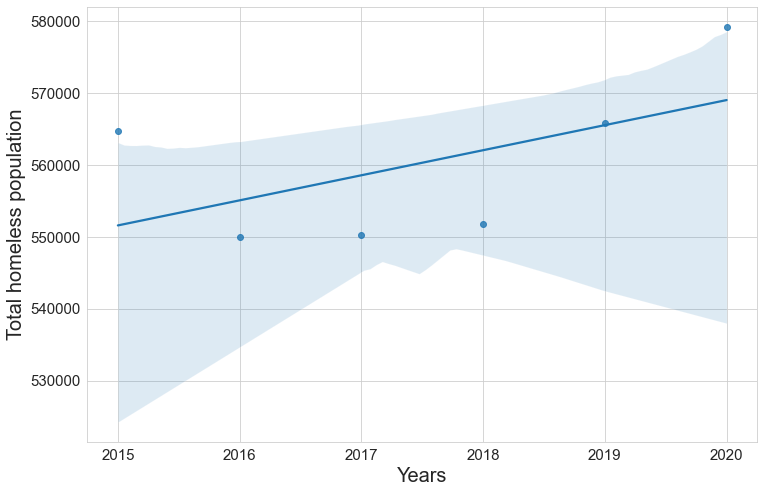

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))
p = sns.regplot(x=total_hom_pop.index, y="homeless_pop", data=total_hom_pop)
p.set_ylabel("Total homeless population", fontsize = 20)
p.set_xlabel("Years", fontsize = 20)
p.tick_params(axis='both', which='major', labelsize=15)

plt.show()

Based on latter calculation, the homeless population has increased since 2018.
## What is its yearly percentage change?

In [57]:
total_hom_pop["Percentage change (%)"] = total_hom_pop["homeless_pop"].pct_change() * 100

In [58]:
total_hom_pop

,homeless_pop,Percentage change (%)
year,,
2015,564708.0,NaN
2016,549928.0,-2.617282
2017,550324.0,0.072009
2018,551786.0,0.265662
2019,565908.0,2.559326
2020,579259.0,2.359217


Since 2018, the total homeless population in the USA has increased in 2.4% yearly
## How has the homeless population changed by state?

In [59]:
# What are the set of years
years = np.sort(df_clean["year"].unique())
print(years)

[2015 2016 2017 2018 2019 2020]


In [60]:
df_clean[df_clean["year"] == 2015].sort_values(by="homeless_pop", ascending=False)

,year,abbreaviation,homeless_pop
27,2015,CA,115738.0
211,2015,NY,88250.0
58,2015,FL,35900.0
275,2015,TX,23678.0
120,2015,MA,21135.0
304,2015,WA,19419.0
237,2015,PA,15421.0
60,2015,GA,13790.0
231,2015,OR,13226.0
94,2015,IL,13177.0


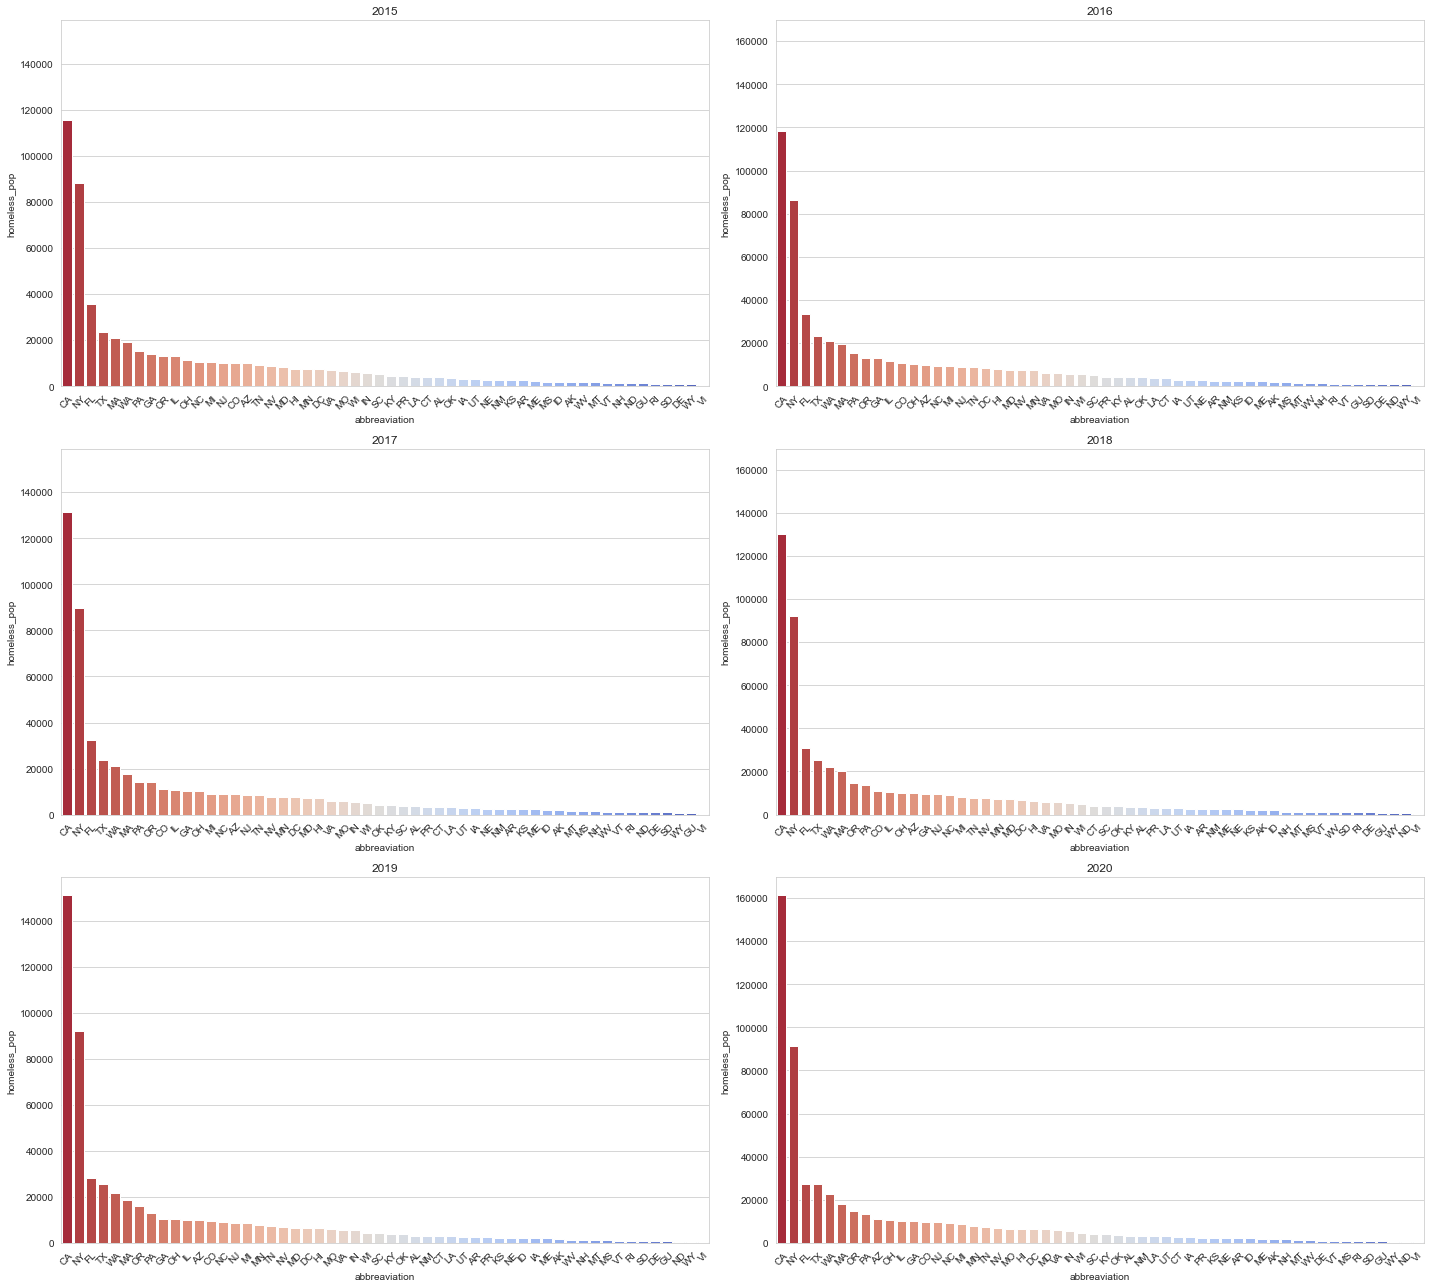

In [61]:
_, axes = plt.subplots(3, 2, figsize=(20, 18), sharey='col')
for year, ax in zip(years, axes.ravel()):
    df2 = df_clean[df_clean["year"] == year].sort_values(by="homeless_pop", ascending=False)
    g = sns.barplot(x="abbreaviation", y="homeless_pop", data=df2,
                    palette="coolwarm_r", ax=ax)
    g.set_title(year)
    plt.sca(ax)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Top 10 States Overall Homeless population from 2016 - 2020

Based on those figures, CA is the state with a higher homeless population. Besides, there were no massive changes in the states with homeless people during the last four years.

Let's see what are the top 10 states

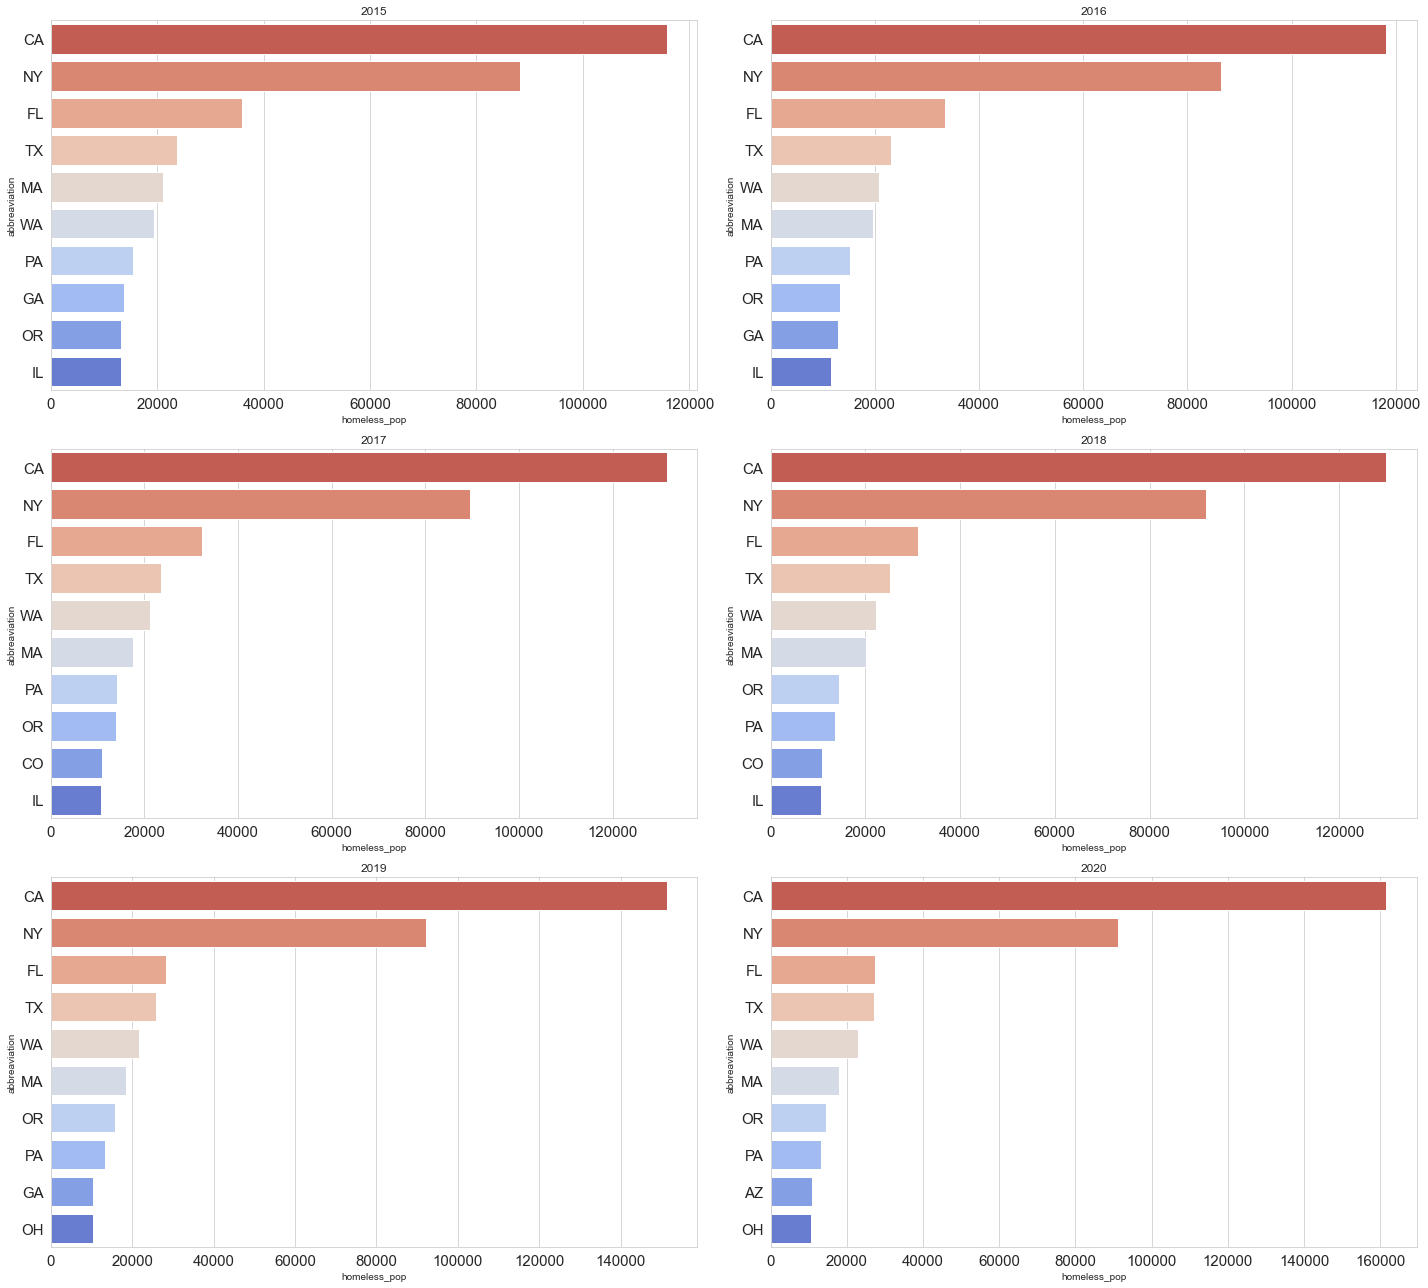

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
for year, ax in zip(years, axes.ravel()):
    df2 = df_clean[df_clean["year"] == year].sort_values(by="homeless_pop", ascending=False)
    g = sns.barplot(y="abbreaviation", x="homeless_pop", data=df2.head(10),
                    palette="coolwarm_r", ax=ax, orient="h")
    g.set_title(year)
    g.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

## Select the top 10 States with higher overall homeless population

The top ten states list isn't kept constant during the period study. Let's find out which states were on the list

In [63]:
list_top_states = []
for year in years:
    list_top_states.extend(df_clean[df_clean["year"] == year].sort_values(by="homeless_pop", ascending=False).head(10).index.to_list())

top_states = list(set(list_top_states))

In [64]:
top_states_df = df_clean.loc[top_states]

In [65]:
top_states_df.reset_index(inplace=True, drop=True)

In [66]:
top_states_df

,year,abbreaviation,homeless_pop
0,2018,TX,25310.0
1,2020,TX,27229.0
2,2016,TX,23122.0
3,2017,TX,23548.0
4,2019,TX,25848.0
5,2015,TX,23678.0
6,2020,AZ,10979.0
7,2020,CA,161548.0
8,2018,CA,129972.0
9,2017,CA,131532.0


In [67]:
name_top_states = top_states_df["abbreaviation"].unique().tolist()
print("There are {} states that has been reported in the top 10 homeless population between {} and {}".format(
    len(name_top_states), min(years), max(years)
))

There are 13 states that has been reported in the top 10 homeless population between 2015 and 2020


In [68]:
query = ("SELECT sr.abbreviation, sr.name, sr.region "
         "FROM state_region AS sr "
         "WHERE sr.abbreviation IN (" + "'" +"','".join(name_top_states) + "')")

In [69]:
cursor = connect_database("heroku", "c1_capstone", keys)
cursor.execute(query)
results = cursor.fetchall()
cursor.close()
which_states = pd.DataFrame(results, columns=['Abbr', 'State', 'Region'])
which_states


,Abbr,State,Region
0,AZ,Arizona,Southwest
1,CA,California,West
2,CO,Colorado,West
3,FL,Florida,South
4,GA,Georgia,South
5,IL,Illinois,Midwest
6,MA,Massachusetts,New England
7,NY,New York,Middle Atlantic
8,OH,Ohio,Midwest
9,OR,Oregon,West


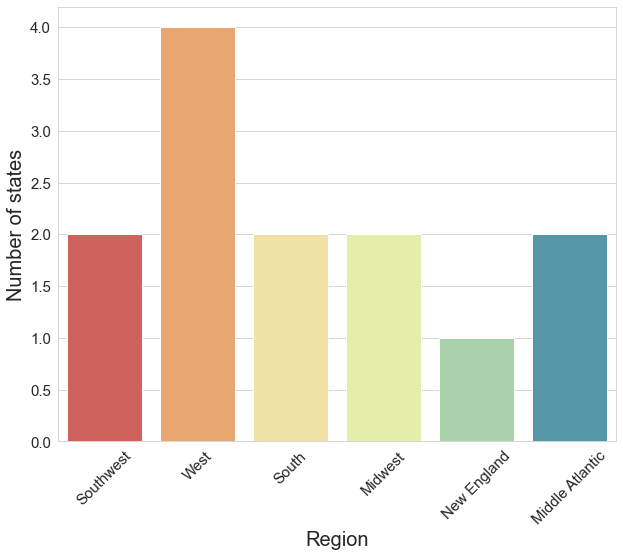

In [70]:
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.countplot(x='Region', data=which_states, palette="Spectral")
ax.set_ylabel('Number of states', fontsize=20)
ax.set_xlabel('Region', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=15, labelrotation=45)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.show()

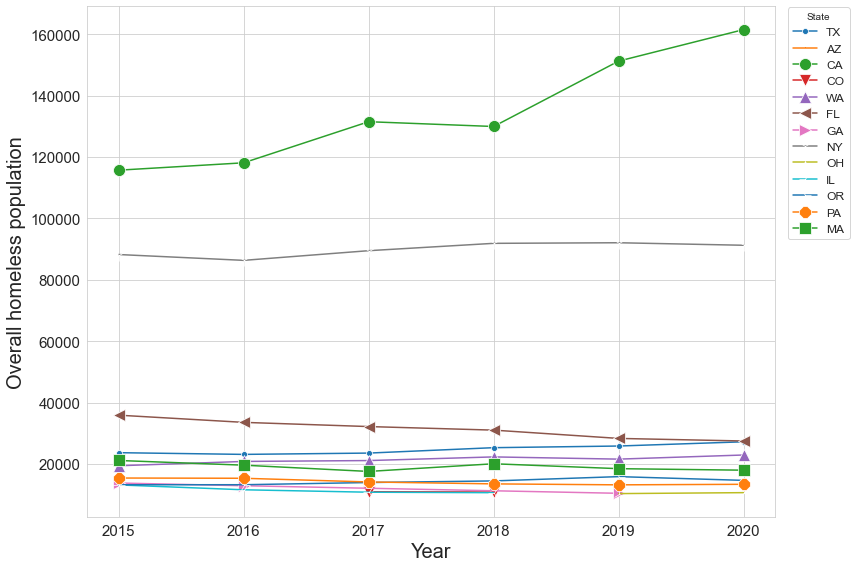

In [71]:
fig, ax = plt.subplots(figsize=(12, 8))
for i, state in enumerate(name_top_states):
    _ = sns.lineplot(x="year", y="homeless_pop", data=top_states_df[top_states_df["abbreaviation"] == state],
                     palette='tab20',
                     marker=all_shapes[i], markersize=12)

ax.set_ylabel('Overall homeless population', fontsize=20)
ax.legend(labels=name_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

Based on this figure, California (CA) is the state where the homelessness population has increased the most from 2018 to 2020. The New York state (NY) has shown a continuous homelessness increase.

In contrast, Florida (FL) has shown a continuous decrease since 2015. Let's see the behaviour of the rest of the states

In [72]:
out_state = ['CA', 'NY', 'FL']
new_top_states = [i for i in name_top_states if i not in out_state]

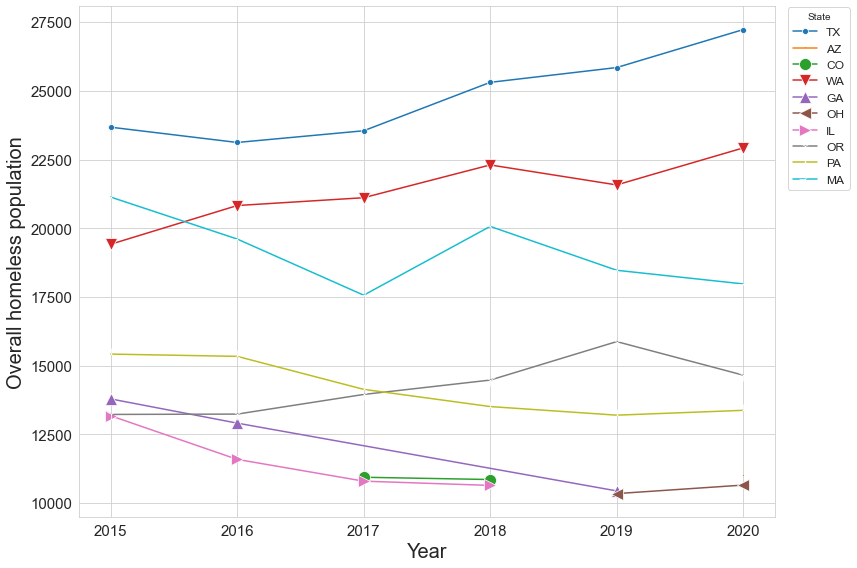

In [73]:
fig, ax = plt.subplots(figsize=(12, 8))
for i, state in enumerate(new_top_states):
    _ = sns.lineplot(x="year", y="homeless_pop", data=top_states_df[top_states_df["abbreaviation"] == state],
                     palette='tab20',
                     marker=all_shapes[i], markersize=12)

ax.set_ylabel('Overall homeless population', fontsize=20)
ax.legend(labels=new_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

## Ratio Homeless population vs Total population in Top States

In [74]:
query = ("SELECT upop.year, sr.abbreviation, upop.population, ovh.homeless_pop "
         "FROM us_population AS upop "
         "JOIN state_region AS sr "
         " ON upop.id_state = sr.state "
         "JOIN overall_homeless ovh "
         " ON (upop.year = ovh.year) AND (sr.abbreviation = ovh.abbreaviation) "
         "WHERE ovh.abbreaviation in ('TX', 'AZ', 'CA', 'CO', 'WA', 'FL', 'GA', 'NY', 'OH', 'IL', 'OR', 'PA', 'MA') "
         "ORDER BY upop.year, upop.id_state ")

In [75]:
cursor = connect_database("heroku", "c1_capstone", keys)
cursor.execute(query)
results = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
cursor.close()

In [76]:
df = pd.DataFrame(results, columns=column_names)

In [77]:
df["% homeless"] = df["homeless_pop"] /df["population"] * 100

In [78]:
df

,year,abbreviation,population,homeless_pop,% homeless
0,2015,AZ,6828065,9896,0.144931
1,2015,CA,39144818,115738,0.295666
2,2015,CO,5456574,9953,0.182404
3,2015,FL,20271272,35900,0.177098
4,2015,GA,10214860,13790,0.134999
...,...,...,...,...,...
73,2020,OH,11675275,10655,0.091261
74,2020,OR,4176346,14655,0.350905
75,2020,PA,12794885,13375,0.104534
76,2020,TX,28635442,27229,0.095088


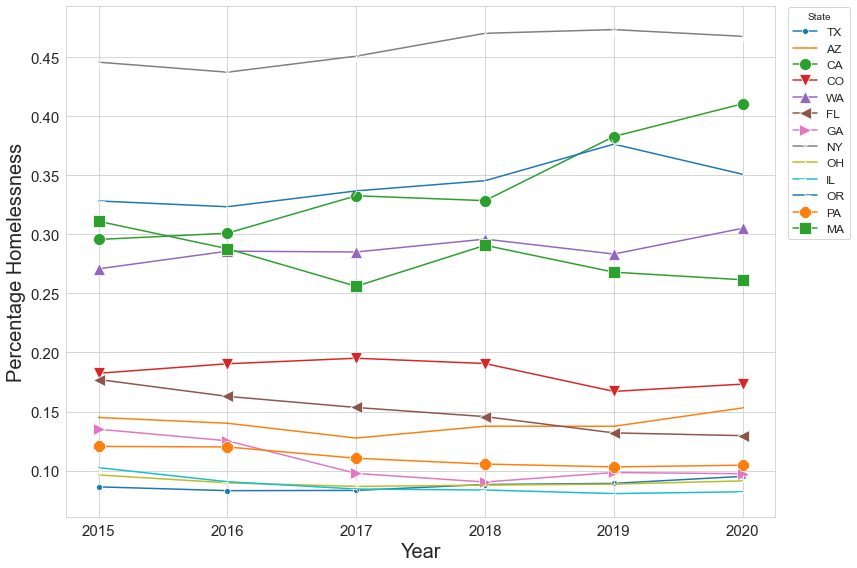

In [79]:
fig, ax = plt.subplots(figsize=(12, 8))
for i, state in enumerate(name_top_states):
    _ = sns.lineplot(x="year", y="% homeless", data=df[df["abbreviation"] == state],
                     palette='tab20',
                     marker=all_shapes[i], markersize=12)

ax.set_ylabel('Percentage Homelessness', fontsize=20)
ax.legend(labels=name_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

In [80]:
df1 = df[df["% homeless"] > 0.25]
df2 = df[df["% homeless"] < 0.25]

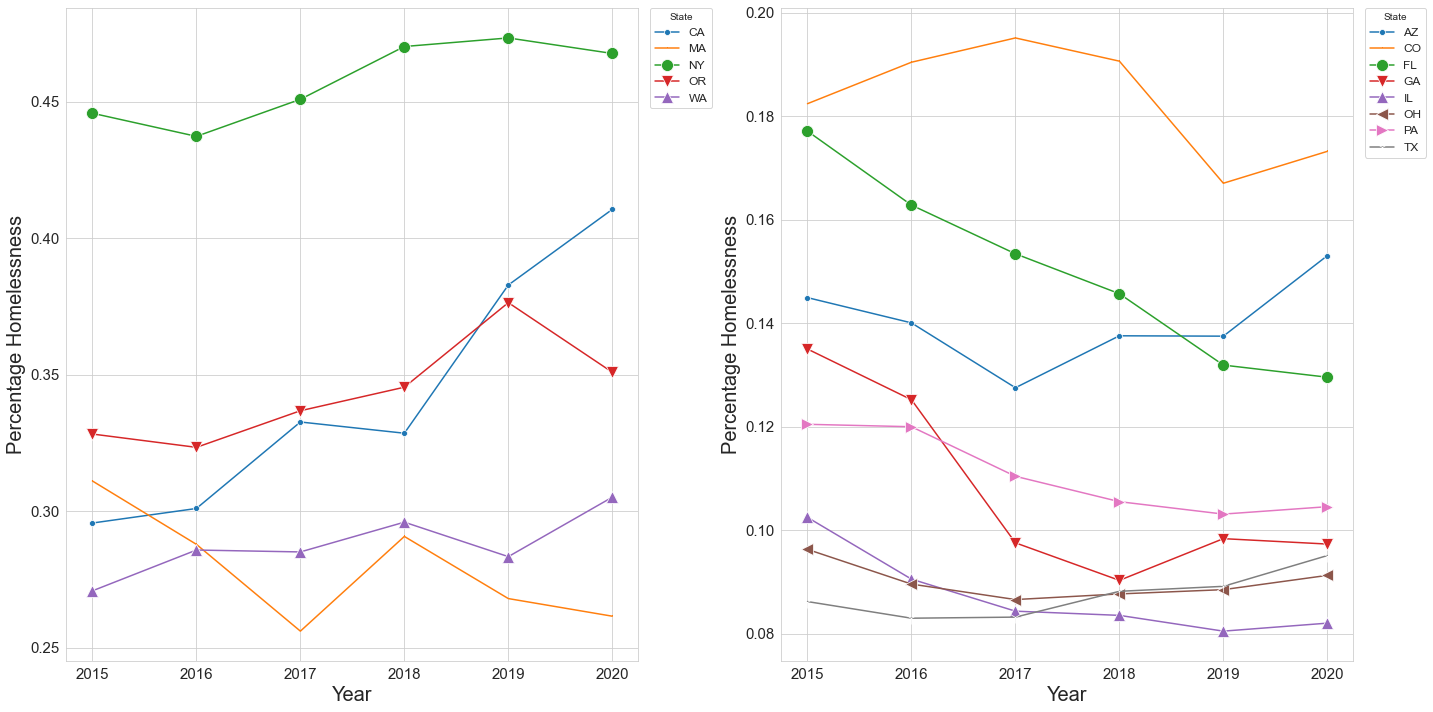

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
for i, state in enumerate(df1["abbreviation"].unique().tolist()):
    _ = sns.lineplot(x="year", y="% homeless", data=df1[df1["abbreviation"] == state],
                     palette='tab20',
                     marker=all_shapes[i], markersize=12, ax=ax1)

ax1.set_ylabel('Percentage Homelessness', fontsize=20)
ax1.legend(labels=df1["abbreviation"].unique().tolist(), title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax1.set_xlabel('Year', fontsize=20)
ax1.tick_params(which='major', labelsize=15)

for i, state in enumerate(df2["abbreviation"].unique().tolist()):
    _ = sns.lineplot(x="year", y="% homeless", data=df2[df2["abbreviation"] == state],
                     palette='tab20',
                     marker=all_shapes[i], markersize=12, ax=ax2)

ax2.set_ylabel('Percentage Homelessness', fontsize=20)
ax2.legend(labels=df2["abbreviation"].unique().tolist(), title = "State",
           fontsize = 'large',
           bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax2.set_xlabel('Year', fontsize=20)
ax2.tick_params(which='major', labelsize=15)

plt.tight_layout()
plt.show()

In [82]:
df.groupby(["abbreviation"])["% homeless"].agg(['mean', 'std']).sort_values(by="std", ascending=False)

,mean,std
abbreviation,,
CA,0.341894,0.045757
MA,0.279207,0.020963
OR,0.343536,0.019093
FL,0.150073,0.018300
GA,0.107287,0.018175
NY,0.457563,0.014874
WA,0.287690,0.011720
CO,0.183129,0.011054
AZ,0.140096,0.008513


From the latter result, it is possible to select the group of states for final comparison and visualization